## Problem Set 4: Bias of an AR(1) Process

Victoria Gregory, N14207660

3/2/2016

*Plots the bias of an AR(1) process for a given set of coefficients and sample sizes.*

First, I'm going to import all the packages I'll need.

In [12]:
import numpy as np
from numpy.linalg import inv
from numba import jit
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

Below, I'm writing a function that will draw an AR(1) process with the given parameters and sample size.

In [28]:
@jit
def AR1_sim(alpha,beta,n,randomvec):
    x = np.empty(n)
    x[0] = beta/(1-alpha)
    for i in range(1,n):
        x[i] = beta + alpha*x[i-1] + randomvec[i-1]
    return x

The function below simply computes a mean of a vector. I wrote this myself because I'll be computing the sample mean to run the regressions in the next function, and it's faster than doing `np.mean`.

In [41]:
@jit
def my_mean(vec):
    mysum = 0
    for i in range(0,np.size(vec)):
        mysum = vec[i] + mysum
    m = mysum/np.size(vec)
    return m

The next function will find the bias of an AR(1). It calls `AR1_sim` `Nsim` times, estimates the parameters of the process, and computes the bias as $\mathbb{E}[\hat{\alpha}] - \alpha$. To estimate $\alpha$, I used a running sum to compute variances and covariances, because `jit` is designed to speed these up.

In [55]:
@jit
def bias_AR1(alpha,beta,n,Nsim):
    estimates = np.empty(Nsim)
    randommat = np.random.randn(n,Nsim)
    for b in range(0,Nsim):
        randomvec = randommat[:,b]
        AR1 = AR1_sim(alpha,beta,n,randomvec)
        covsum = 0
        varsum = 0
        ARmean = my_mean(AR1)
        for t in range(0,n-1):
            covterm = (AR1[t] - ARmean)*(AR1[t+1] - ARmean)
            varterm = (AR1[t] - ARmean)**2
            covsum = covterm + covsum
            varsum = varterm + varsum
        estimates[b] = covsum/varsum
    bias = np.mean(estimates) - alpha
    return bias

Now I'm setting up vectors for the $\alpha$ values and sample sizes I want to evaluate the bias for.

In [43]:
alphas = [0.5, 0.6, 0.7, 0.8, 0.9]
ns = np.linspace(50,500,10)
Nsim = 10000
biases = np.empty([len(alphas),np.size(ns)]) 

For each one of these, I'm calling `bias_AR1` and saving the output for plotting later. This takes a little bit under 3 minutes to run.

In [53]:
start_time = timeit.default_timer()
for n in range(0,np.size(ns)):
    for a in range(0,len(alphas)): 
        biases[a,n] = bias_AR1(alphas[a],1,int(ns[n]),Nsim)
elapsed = timeit.default_timer() - start_time
print(elapsed)

166.52538680699945


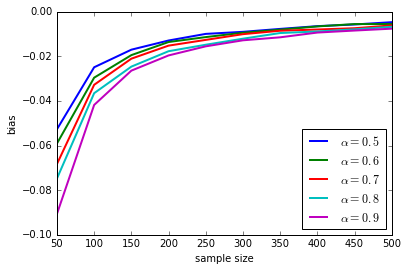

In [52]:
fig, ax = plt.subplots()
for a in range(0,len(alphas)):
    current_label = r'$\alpha = {0:.1f}$'.format(alphas[a])
    ax.plot(ns, biases[a,:], linewidth=2, label=current_label)
ax.legend(loc='lower right')
ax.set_xlabel('sample size')
ax.set_ylabel('bias')
plt.show()

The bias is more pronounced for smaller sample sizes and larger $\alpha$'s.